<a href="https://colab.research.google.com/github/HuyHuynh-Milo/Ecommerce-Inactive-Customers-Prediction-Python-/blob/main/%5BProject3%5D_Q_Huy_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Quick EDA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install openpyxl
file_path = '/content/drive/MyDrive/Machine Learning/Unigap/Project3/churn_prediction.xlsx'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

churn_raw = pd.read_excel(file_path,engine = 'openpyxl')

In [ ]:
print(churn_raw.head(10))

   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       52869      0    20.0         Mobile Phone         3              7.0   
1       52942      0    13.0             Computer         1              9.0   
2       52972      0    16.0         Mobile Phone         3              7.0   
3       53125      0     5.0         Mobile Phone         1             16.0   
4       53367      0     9.0         Mobile Phone         1             28.0   
5       53544      0     1.0         Mobile Phone         1             16.0   
6       53566      0    18.0         Mobile Phone         1             36.0   
7       53583      1     1.0             Computer         1             17.0   
8       53762      0    23.0         Mobile Phone         1             10.0   
9       53766      0     6.0         Mobile Phone         1             17.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0             E wallet  Female             

In [ ]:
print(churn_raw.shape)
print(churn_raw.info())

(5630, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberO

In [ ]:
# Check duplicated rows
churn_raw.duplicated().any()

np.False_

In [ ]:
# Check unique value each columns
info_df = pd.DataFrame({
    'Dtype' : churn_raw.dtypes,
    'Unique' : churn_raw.nunique(),
    'Non-null' : churn_raw.notnull().sum()
})
print(info_df)


                               Dtype  Unique  Non-null
CustomerID                     int64    5630      5630
Churn                          int64       2      5630
Tenure                       float64      36      5366
PreferredLoginDevice          object       3      5630
CityTier                       int64       3      5630
WarehouseToHome              float64      34      5379
PreferredPaymentMode          object       7      5630
Gender                        object       2      5630
HourSpendOnApp               float64       6      5375
NumberOfDeviceRegistered       int64       6      5630
PreferedOrderCat              object       6      5630
SatisfactionScore              int64       5      5630
MaritalStatus                 object       3      5630
NumberOfAddress                int64      15      5630
Complain                       int64       2      5630
OrderAmountHikeFromlastYear  float64      16      5365
CouponUsed                   float64      17      5374
OrderCount

- We have 5630 distinct customer and the object data type columns (categoical feature) have kinda few distinct value

## a. Predict null values by using ML

In [ ]:
# Check some info of null values:

# Check percentage of row that have missing value
null_percent = churn_raw.isnull().any(axis = 1).mean()*100
print('Row have null percent:',null_percent,'\n')

# Check percentage of null in each col
null_eachcol = churn_raw.isnull().mean()*100
null_percent_eachcol = null_eachcol[null_eachcol > 0].sort_values(ascending = False)
# print('Percent of null each row:\n',null_percent_eachcol)

# Show the data type of those columns:
columns_select = null_percent_eachcol.index
df_select = churn_raw[columns_select]
# print(df_select.dtypes)

# Combine these 2 series into df with unique_value column
null_info = pd.DataFrame({
    'Null_percentage' : null_percent_eachcol,
    'Data_type' : df_select.dtypes,
    'unique_value': df_select.nunique()
})
print(null_info)

Row have null percent: 32.96625222024866 

                             Null_percentage Data_type  unique_value
DaySinceLastOrder                   5.452931   float64            22
OrderAmountHikeFromlastYear         4.706927   float64            16
Tenure                              4.689165   float64            36
OrderCount                          4.582593   float64            16
CouponUsed                          4.547069   float64            17
HourSpendOnApp                      4.529307   float64             6
WarehouseToHome                     4.458259   float64            34


-> As the null percent of each columns is approximately 5% and those are all float type, we can use **ML Model** to predict

In [ ]:
# RUN THIS
# Using Random Forest model to predict null values
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

churn_filled = churn_raw.copy()
# Create loop through the churn_raw column
for col in churn_filled.columns:
  if churn_filled[col].isnull().sum() == 0:
    continue  # leave out the non null columns

  # Split the data into two parts: rows with values and rows with nulls
  know_df = churn_filled[churn_filled[col].notnull()]
  unknow_df = churn_filled[churn_filled[col].isnull()]

  # Create X_train, y_train Drop the target column (column has null) from features
  X_train = know_df.drop(columns = [col])
  y_train = know_df[col]
  X_pred = unknow_df.drop(columns = [col])

  # Fill other missing value with -999
  X_train = X_train.fillna(-999)
  X_pred = X_pred.fillna(-999)

  # Encode categorical columns with one-hot encoding
  X_train = pd.get_dummies(X_train)
  X_pred = pd.get_dummies(X_pred)

  # Align columns between train and prediction
  X_pred = X_pred.reindex(columns = X_train.columns, fill_value = 0)

  # Chose model to train:
  if y_train.dtype == 'object' or y_train.nunique() < 10:
    model = RandomForestClassifier(random_state = 42)
  else:
    model = RandomForestRegressor(random_state = 42)

  # Train and predict
  model.fit(X_train, y_train)
  predicted = model.predict(X_pred)

  # Fill the missing value with prediction
  churn_filled.loc[churn_raw[col].isnull(), col] = predicted


In [ ]:
print("All missing values have been filled.")
print(churn_filled.info())

All missing values have been filled.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5630 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5630 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5630 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-n

## b. Data distribution and outliers

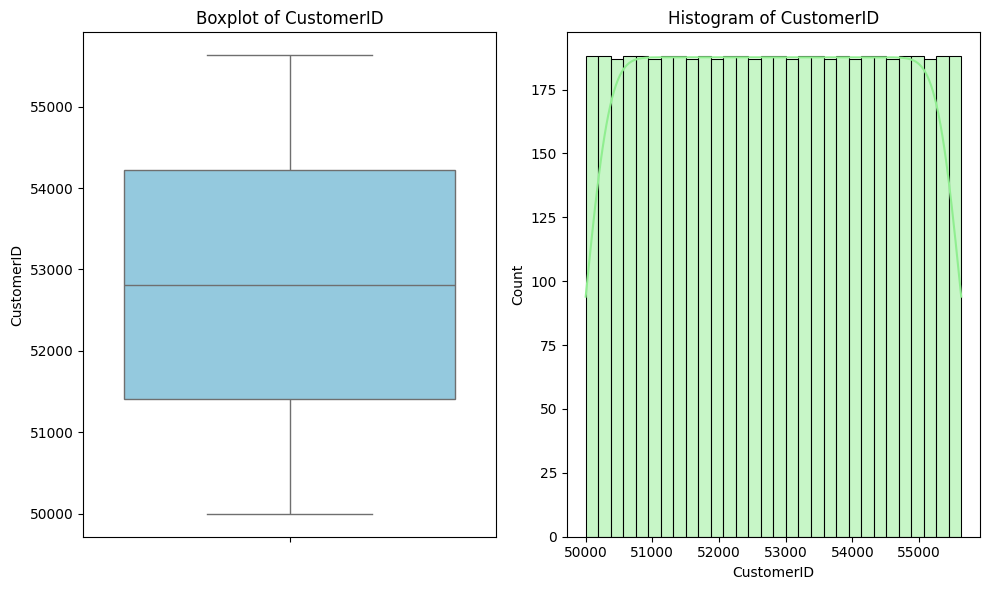

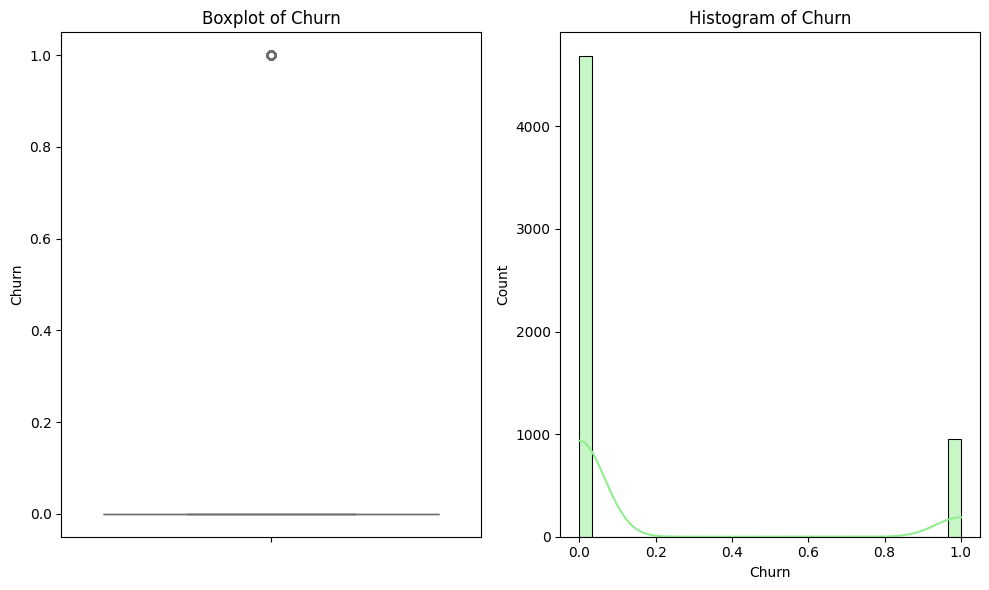

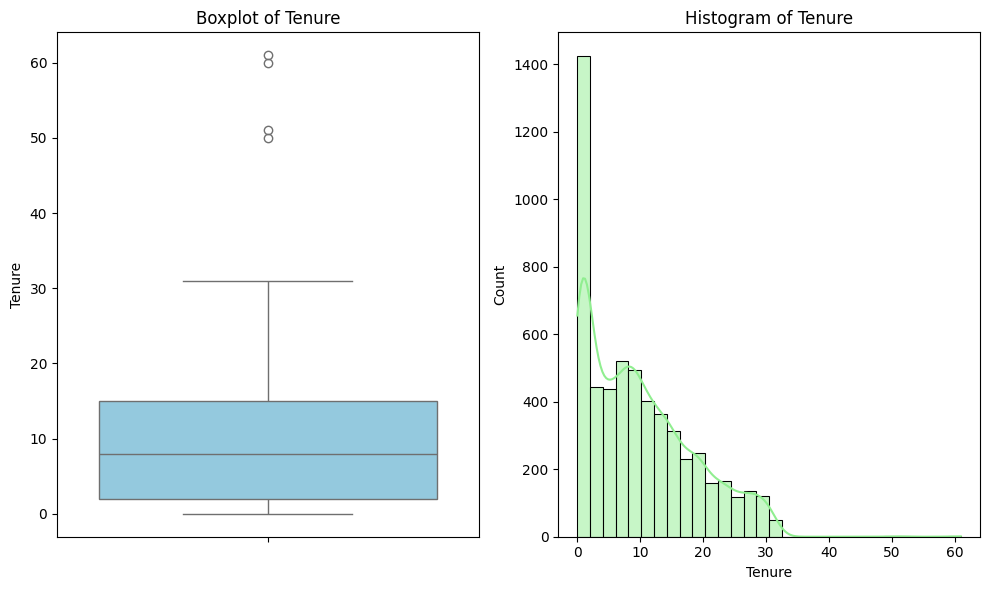

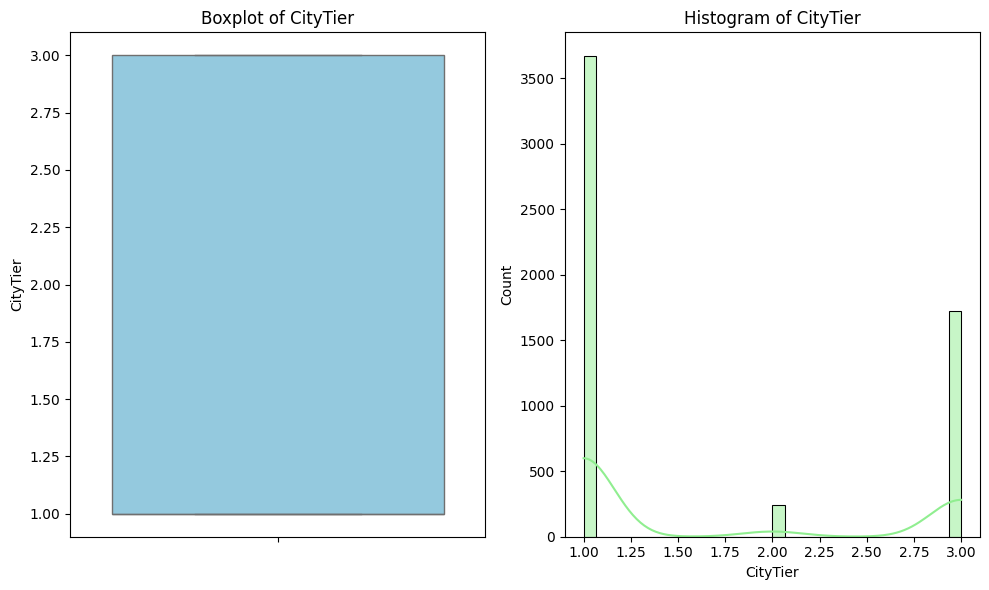

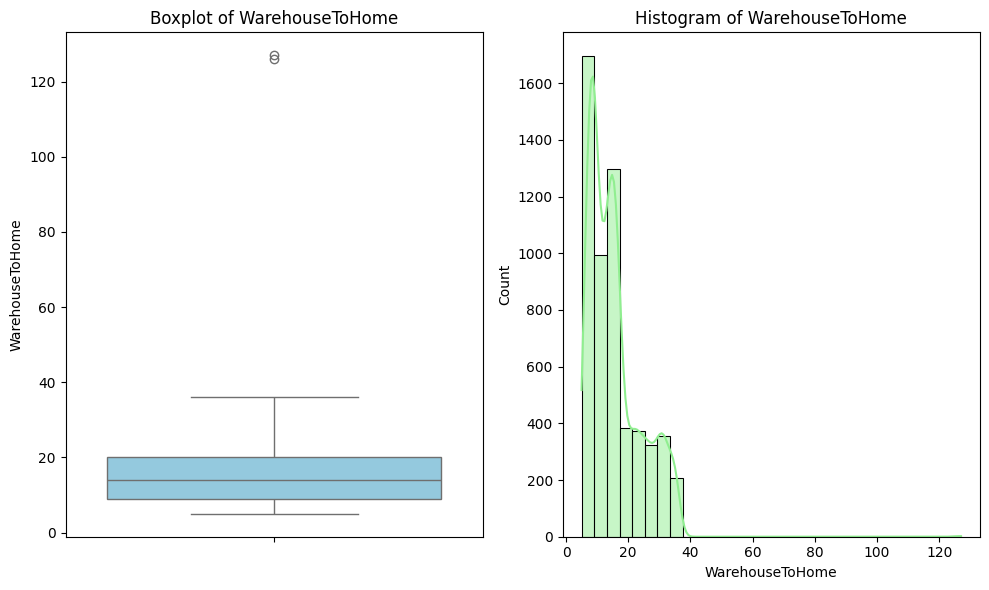

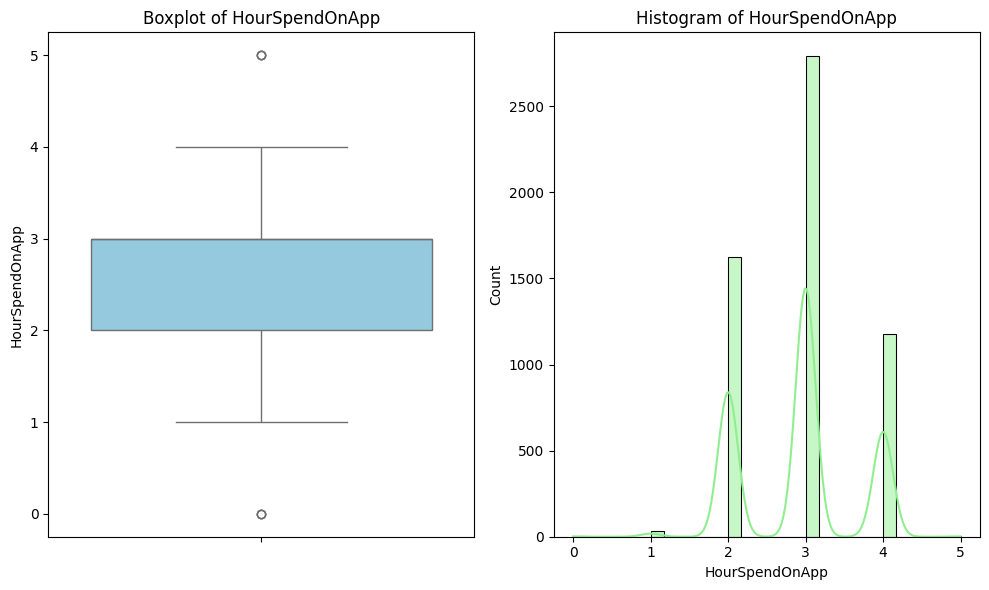

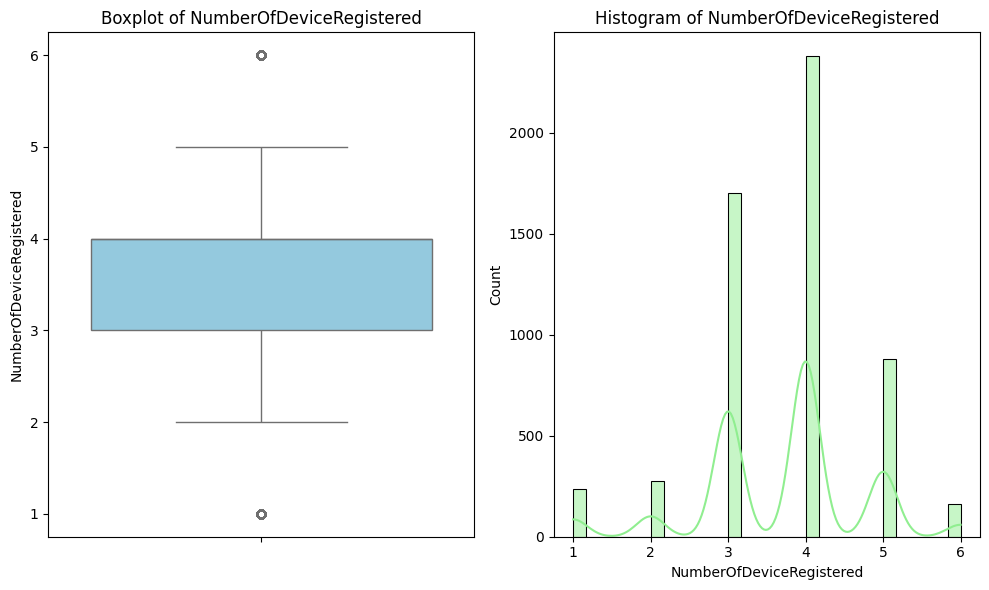

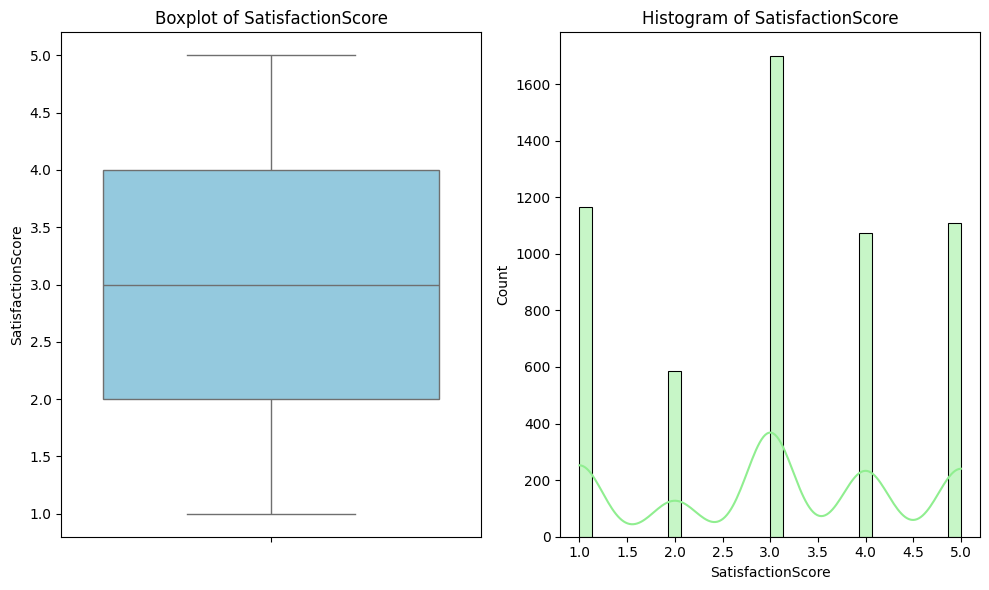

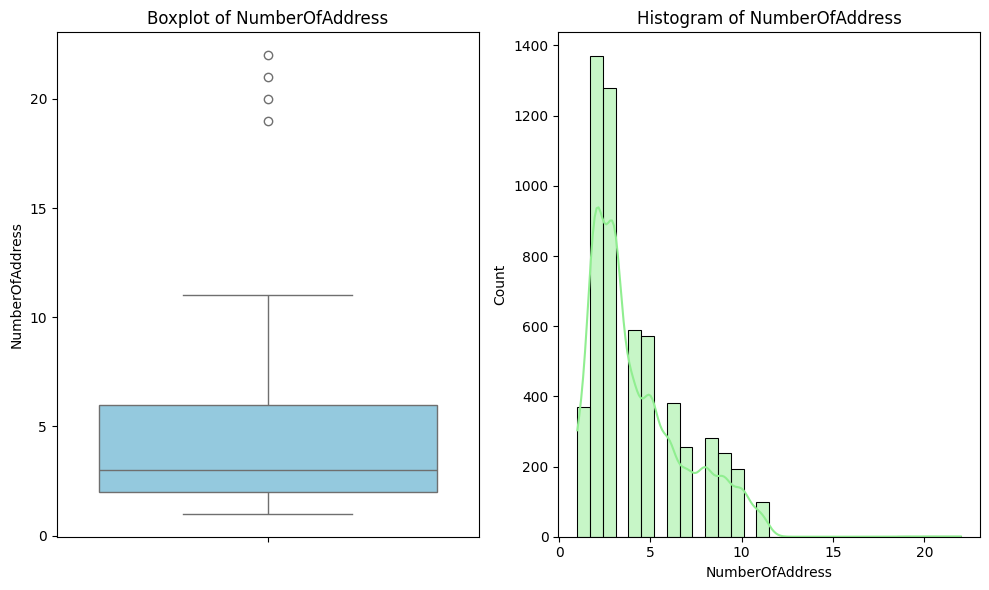

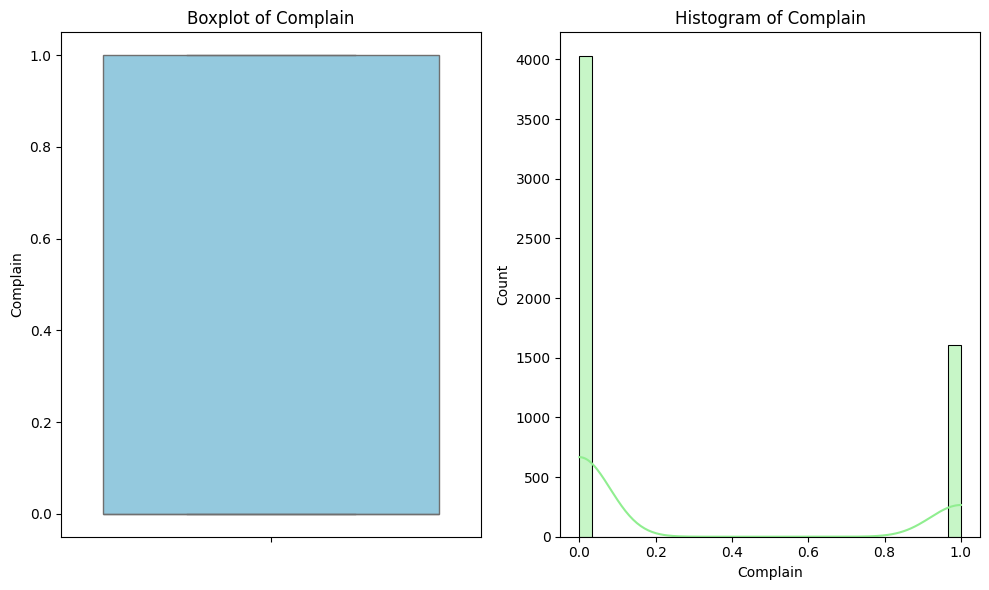

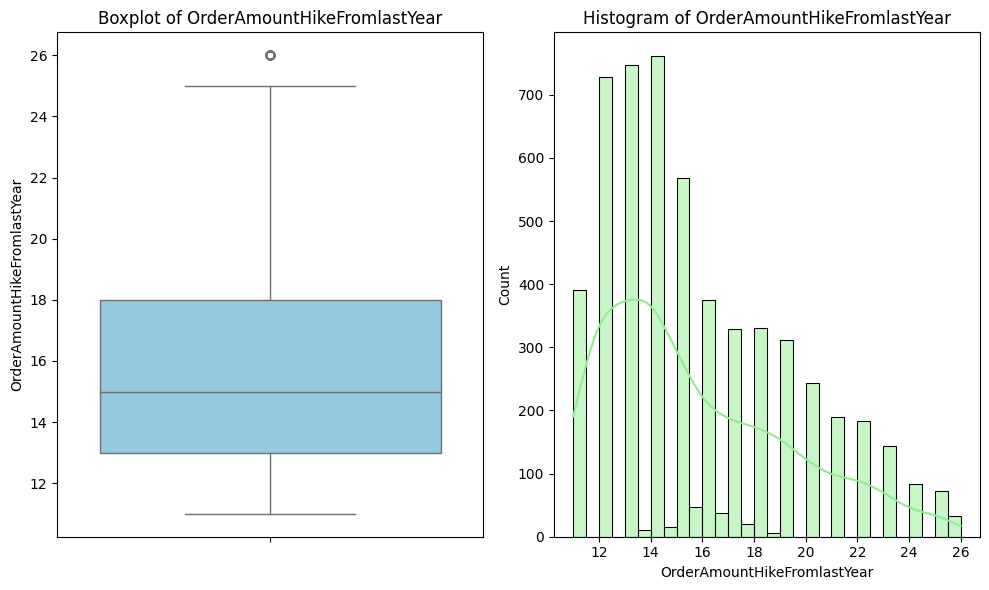

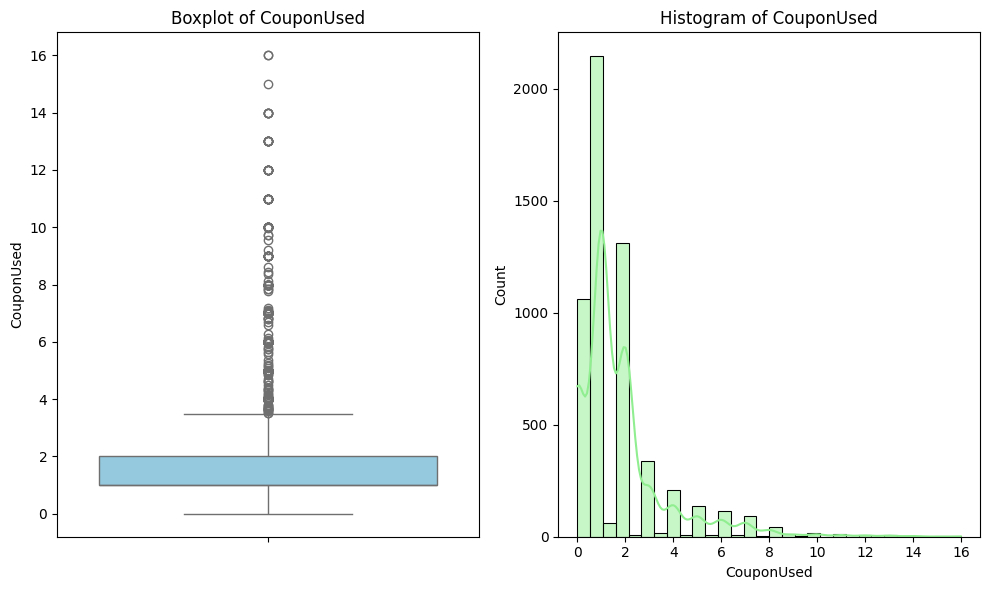

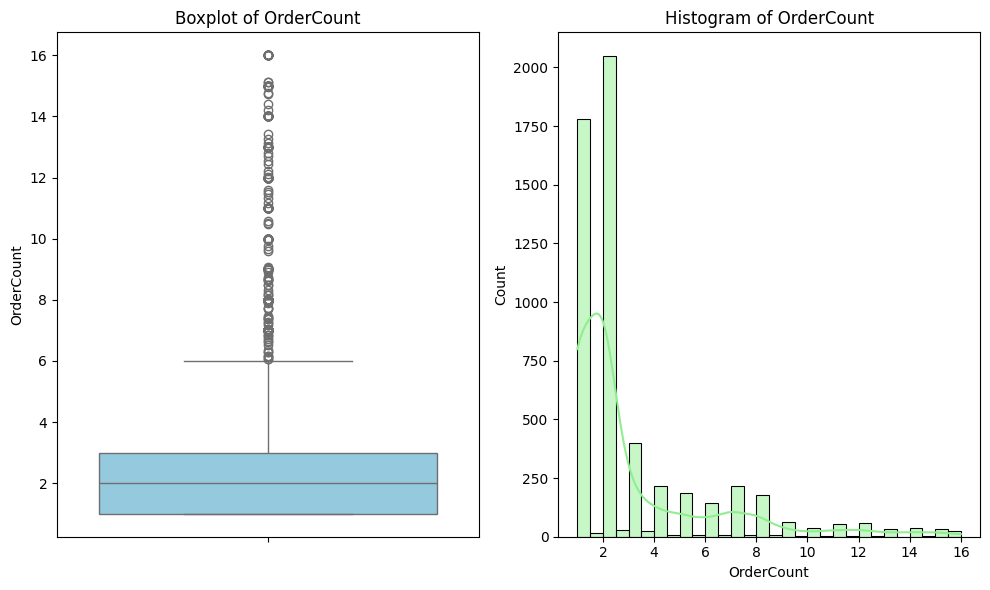

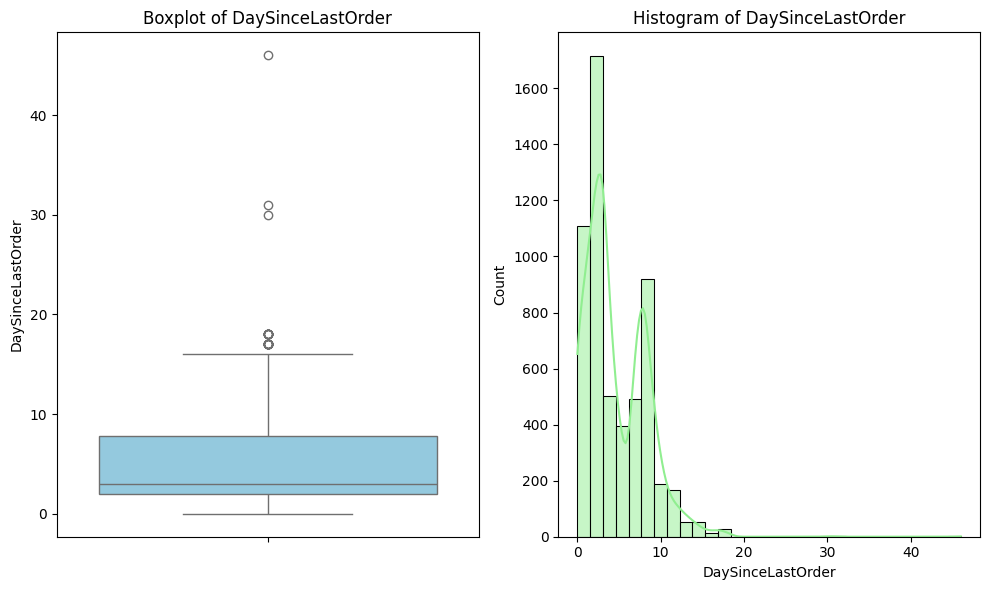

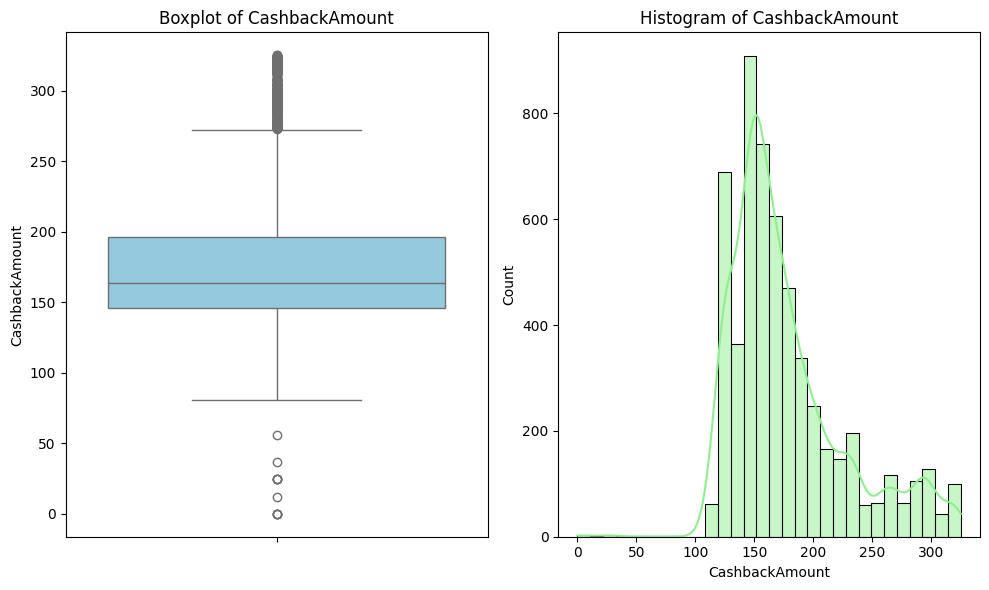

In [ ]:
# Check the distribution of numeric data
import seaborn as sns
import matplotlib.pyplot as plt

cols = churn_filled.select_dtypes(exclude=['object'])

for col in cols:
  plt.figure(figsize=(10, 6))

# Boxplot on left
  plt.subplot(1, 2, 1)
  sns.boxplot(y=churn_filled[col], color='skyblue')
  plt.title(f'Boxplot of {col}')

# Histogram on right
  plt.subplot(1, 2, 2)
  sns.histplot(churn_filled[col], kde=True, bins=30, color='lightgreen')
  plt.title(f'Histogram of {col}')

  plt.tight_layout()
  plt.show()


- As these plot show the outliers of 4 columns are unreasonably large, it maybe by some mistake of collecting data => Delete those outliers row

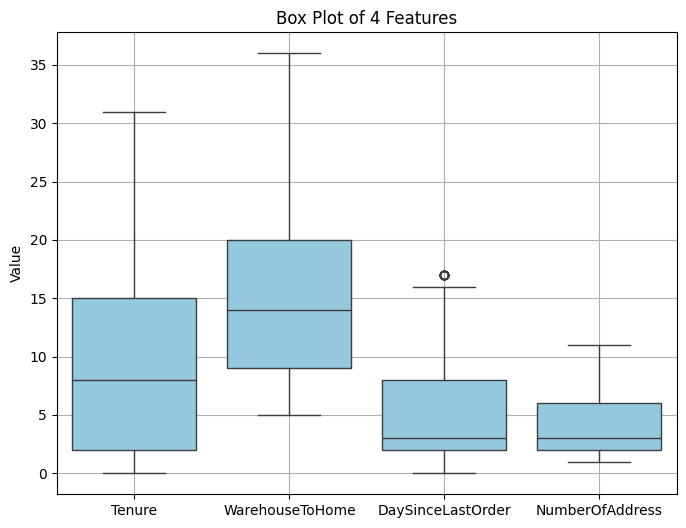

After removing outliers: (5607, 20)


In [ ]:
# RUN THIS
# Remove outliers of these 4 numeric columns
cols = ['Tenure','WarehouseToHome','DaySinceLastOrder','NumberOfAddress']

churn_filtered = churn_filled.copy()

# Using IQR to indicate outliers
for col in cols:
    Q1 = churn_filtered[col].quantile(0.25)
    Q3 = churn_filtered[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    churn_filtered = churn_filtered[(churn_filtered[col] >= lower) & (churn_filtered[col] <= upper)]

# Draw a box plot to check the remove of outliers

plt.figure(figsize=(8, 6))
sns.boxplot(data =  churn_filtered[cols], color = 'skyblue')
plt.title('Box Plot of 4 Features')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Shape of df after remove outliers
print(f"After removing outliers: {churn_filtered.shape}")

- Check some correlation:

<Axes: >

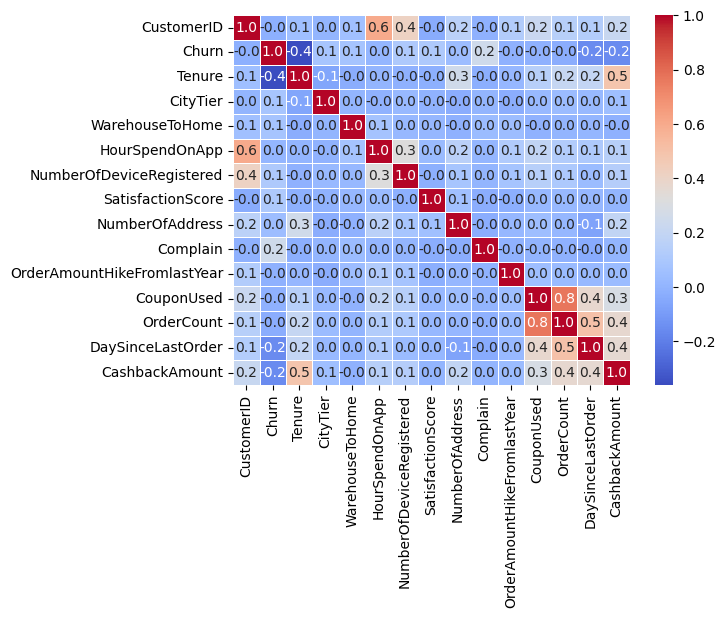

In [ ]:
corr = num_cols.corr()
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.7)

The Tenure has weak negative correlation to churn, so perhaps long time customer have fewer intention to leave.


- **From now on we will name our dataframe "churn_df" **

In [ ]:
# RUN THIS
churn_df = churn_filtered.copy()
# print(churn_df.info(), churn_df.dist)

In [ ]:
# RUN THIS
num_cols = churn_df.select_dtypes(exclude = ['object'])
cate_cols = churn_df.select_dtypes(include = ['object'])
# print(cate_cols.info())

In [ ]:
# Unique Value of categorical Features
for col in cate_cols.columns:
  print(f'unique value of {col}:')
  print(cate_cols[col].unique())

unique value of PreferredLoginDevice:
['Mobile Phone' 'Computer' 'Phone']
unique value of PreferredPaymentMode:
['E wallet' 'Cash on Delivery' 'Debit Card' 'Credit Card' 'COD' 'CC' 'UPI']
unique value of Gender:
['Female' 'Male']
unique value of PreferedOrderCat:
['Fashion' 'Laptop & Accessory' 'Mobile Phone' 'Grocery' 'Mobile' 'Others']
unique value of MaritalStatus:
['Married' 'Single' 'Divorced']


We can see that the data have some mistake over similar features. For example, there is 2 type of payment method which have the same meaning: "cash on Delivery" and "COD". So here the fix:
- PreferredLoginDevice: Phone = Mobile Phone
- PreferredPaymentMode: Credit Card = CC & Cash On Delivery = COD
- PreferedOrderCat: Mobile = Mobile Phone

In [ ]:
# RUN THIS
# Change these category name
churn_df['PreferredLoginDevice'] = churn_df['PreferredLoginDevice'].replace('Phone', 'Mobile Phone')
churn_df['PreferredPaymentMode'] = churn_df['PreferredPaymentMode'].replace('Credit Card','CC')
churn_df['PreferredPaymentMode'] = churn_df['PreferredPaymentMode'].replace('Cash on Delivery','COD')
churn_df['PreferedOrderCat'] = churn_df['PreferedOrderCat'].replace('Mobile', 'Mobile Phone')


In [ ]:
print(churn_df['PreferredPaymentMode'].unique())
print(churn_df['PreferredLoginDevice'].unique())
print(churn_df['PreferedOrderCat'].unique())

['E wallet' 'COD' 'Debit Card' 'CC' 'UPI']
['Mobile Phone' 'Computer']
['Fashion' 'Laptop & Accessory' 'Mobile Phone' 'Grocery' 'Others']


In [ ]:
# RUN THIS
num_cols = churn_df.select_dtypes(exclude = ['object'])
cate_cols = churn_df.select_dtypes(include = ['object'])
# print(cate_cols['PreferredPaymentMode'].unique())

# 2. Feature Importance to Churn

## a. Top important Feature

In [ ]:
# ML model to measure features importances
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Prepare data
X = churn_df.drop('Churn', axis = 1)
y = churn_df['Churn']
X_encoded = pd.get_dummies(X, drop_first = True)
# print(X.shape,X_encoded.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, stratify = y, random_state = 42 )

# Create train model
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

# Get Feature Importance
importances = model.feature_importances_
feature_names = X_train.columns

# Create and sort dataframe for drawing barplot
importance_df = pd.DataFrame({
    'Feature' : feature_names,
    'Importances' : importances
}).sort_values(by = 'Importances', ascending = False)
print(importance_df.shape)

# Create Barplot
# plt.figure(figsize = (10,6))
# sns.barplot(x = 'Importances', y = 'Feature', data = importance_df)
# plt.title('Importance of Features to Churn')
# plt.tight_layout()
# plt.show()

(30, 2)


- We have to unencode the category features

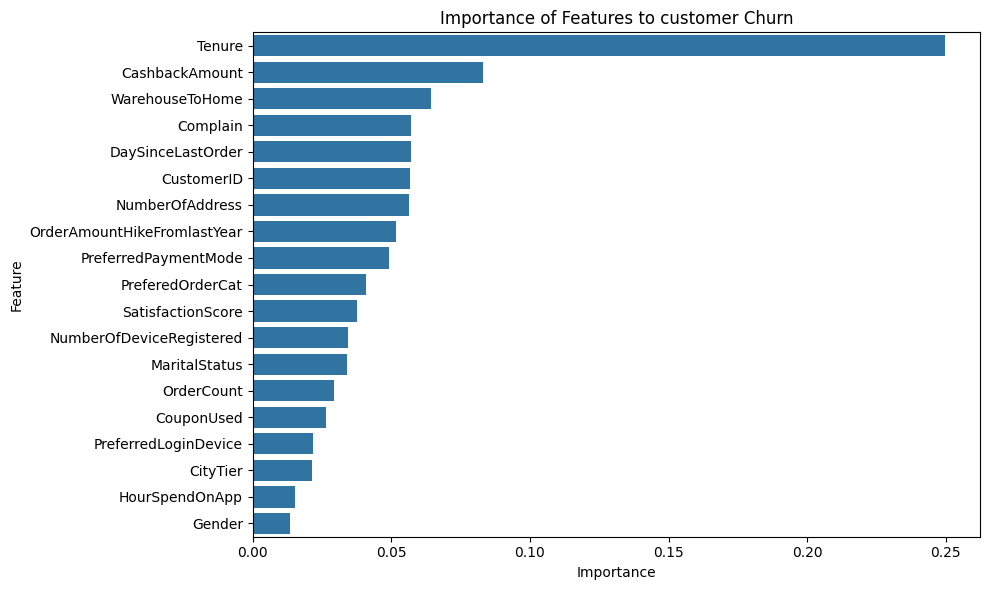

In [ ]:
# Draw a plot for the importance data with the original categories (without encode)
import re

# Function to extract base (original) feature name
def get_base_feature(col):
    return re.split(r'_[^_]+$', col)[0] if '_' in col else col

# Add base feature column
importance_df['BaseFeature'] = importance_df['Feature'].apply(get_base_feature)
# print(importance_df)

# Group importances by base feature
grouped_importance = importance_df.groupby('BaseFeature')['Importances'].sum().reset_index()
grouped_importance = grouped_importance.sort_values(by='Importances', ascending=False)
# print(grouped_importance)

# Plot grouped feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='BaseFeature', data=grouped_importance)
plt.title('Importance of Features to customer Churn')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

So the top 5 things to effect the most on the churn is:
- Tenure,
- Chash back,
- Distance from warehouse to customer,
- Complain
- Day since last order.

Dive into these features and find some insight:



*   For future customer segmentation purpose, assume that there are 4 type of customer behavior by the churn.
*   Split the data of those features into 4 group to see how the trend be like



/tmp/ipython-input-10-2634367144.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate = churn_quantile.groupby(f'{col}_Quantile')['Churn'].mean().reset_index()
/tmp/ipython-input-10-2634367144.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = f'{col}_Quantile', y = 'Churn', data = churn_rate, palette = blue_palette)


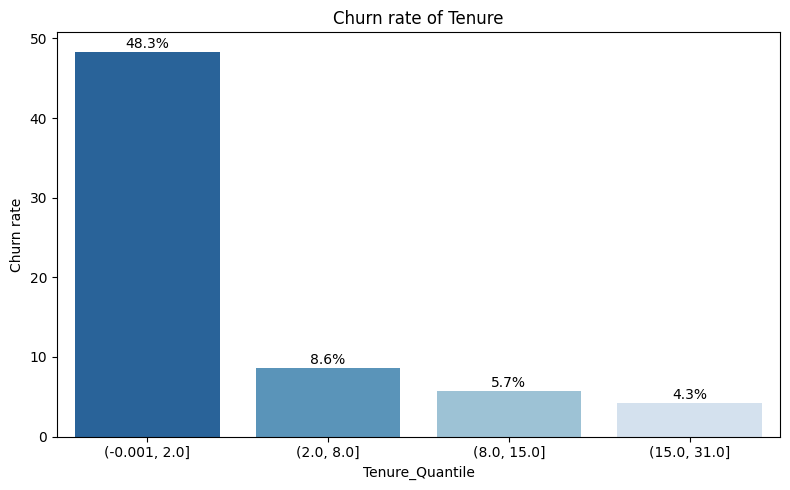

/tmp/ipython-input-10-2634367144.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate = churn_quantile.groupby(f'{col}_Quantile')['Churn'].mean().reset_index()
/tmp/ipython-input-10-2634367144.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = f'{col}_Quantile', y = 'Churn', data = churn_rate, palette = blue_palette)


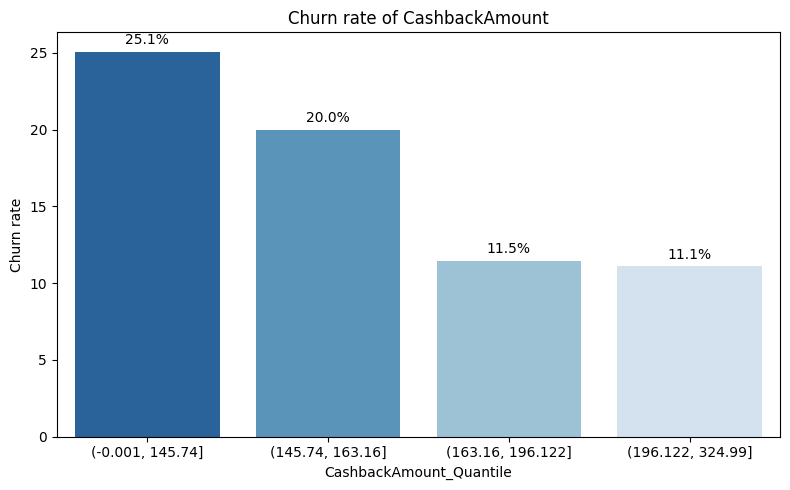

/tmp/ipython-input-10-2634367144.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate = churn_quantile.groupby(f'{col}_Quantile')['Churn'].mean().reset_index()
/tmp/ipython-input-10-2634367144.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = f'{col}_Quantile', y = 'Churn', data = churn_rate, palette = blue_palette)


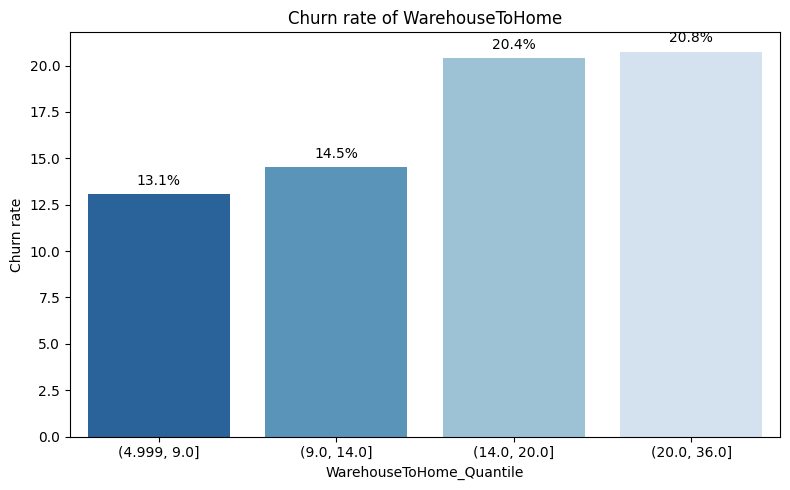

/tmp/ipython-input-10-2634367144.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate = churn_quantile.groupby(f'{col}_Quantile')['Churn'].mean().reset_index()
/tmp/ipython-input-10-2634367144.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = f'{col}_Quantile', y = 'Churn', data = churn_rate, palette = blue_palette)


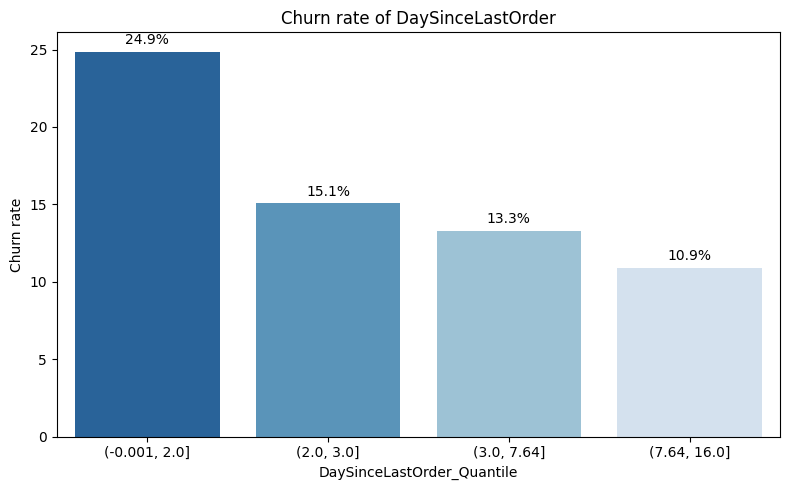

/tmp/ipython-input-10-2634367144.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Complain', y = 'Churn', data = complain_churn_rate, palette = blue_palette)


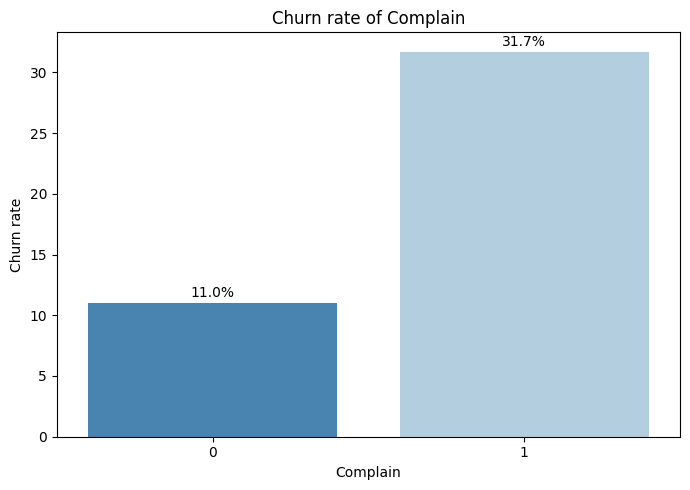

,DaySinceLastOrder_Quantile,Churn
0,"(-0.001, 2.0]",24.868282
1,"(2.0, 3.0]",15.059588
2,"(3.0, 7.64]",13.265306
3,"(7.64, 16.0]",10.880458


In [ ]:
# Dive into these features
important_cols = ['Tenure','CashbackAmount','WarehouseToHome','DaySinceLastOrder']

churn_quantile = churn_df.copy()

# Create a loop through these column to calculate % churn each category
for col in important_cols:
  # Using qcut to cut the quantile to 4
  churn_quantile[f'{col}_Quantile'] = pd.qcut(churn_quantile[col],q = 4)

  # Create churn_rate df to store % churn
  churn_rate = churn_quantile.groupby(f'{col}_Quantile')['Churn'].mean().reset_index()
  churn_rate['Churn'] = churn_rate['Churn']*100
  churn_rate = churn_rate.sort_values(by = 'Churn', ascending = False)

  # Plot these features:
  plt.figure(figsize= (8,5))
  blue_palette = sns.color_palette("Blues", n_colors = len(churn_rate))[::-1] # Setting color of the bars
  sns.barplot(x = f'{col}_Quantile', y = 'Churn', data = churn_rate, palette = blue_palette)

  # Create number on columns head
  for i,row in churn_rate.iterrows():
    plt.text(x = i, y = row['Churn'] + 0.5, s = f"{row['Churn']:.1f}%", ha= 'center')

  # Plot
  plt.title(f'Churn rate of {col}')
  plt.ylabel('Churn rate')
  plt.tight_layout()
  plt.show()


# Create % Churn for Complain Feature:
complain_churn_rate = churn_quantile.groupby('Complain')['Churn'].mean().reset_index()
complain_churn_rate['Churn'] = complain_churn_rate['Churn']*100

# Plot % Churn for complain
plt.figure(figsize= (7,5))
blue_palette = sns.color_palette("Blues", n_colors = len(complain_churn_rate))[::-1]
sns.barplot(x = 'Complain', y = 'Churn', data = complain_churn_rate, palette = blue_palette)

for i,row in complain_churn_rate.iterrows():
  plt.text(x = i, y = row['Churn']+ 0.5, s = f"{row['Churn']:.1f}%", ha='center')

plt.title('Churn rate of Complain')
plt.ylabel('Churn rate')
plt.tight_layout()
plt.show()


Some information from that plot:
- For the Tenure: These user who use the app for 1 month or less have the churn rate of 53%, but the user that last more than 6 month have very few intention to quit, just less than 6%.
> So the reccomendations is to make customer want to extend their time using company's services
- For the CashBack Amount: The churn rate of those who got the cashback >163$ is much fewer than those got less cashback
> But for more information, get features about discount, gift, voucher to understand more about the trend
- For the Warehouse to Home: The more distance from warehouse to customer home, the more likely they will leave.
> Investigate the delivery duration to know the reason of that trend
- For DaysinceLastOrder: A lot of People that make orders in recent days churned
> Find out what is happening with UX/UI
- For Complain: People complain more tend to churn more
> Was the complaint be dealt with correctly?

## b. Categorical data

### Investigate the churn percentage of categorical features

/tmp/ipython-input-46-1577509195.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = churn_pct.index, y = churn_pct.values, palette='viridis')


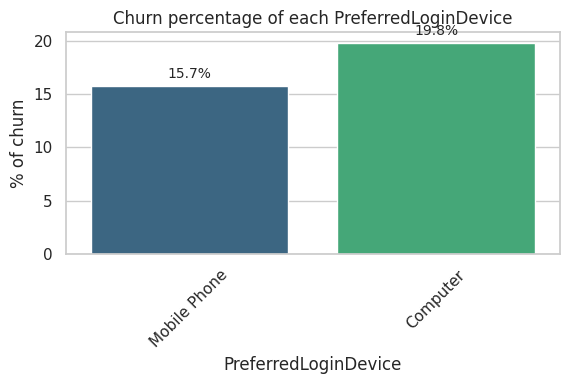

/tmp/ipython-input-46-1577509195.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = churn_pct.index, y = churn_pct.values, palette='viridis')


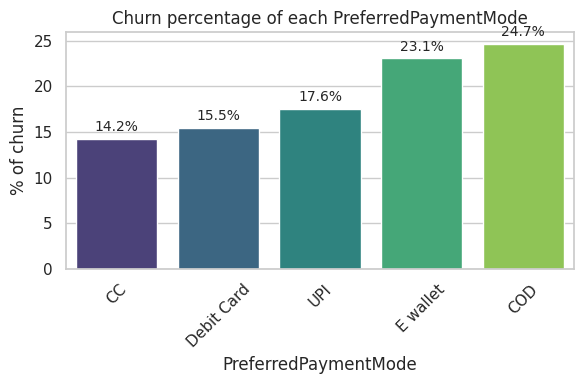

/tmp/ipython-input-46-1577509195.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = churn_pct.index, y = churn_pct.values, palette='viridis')


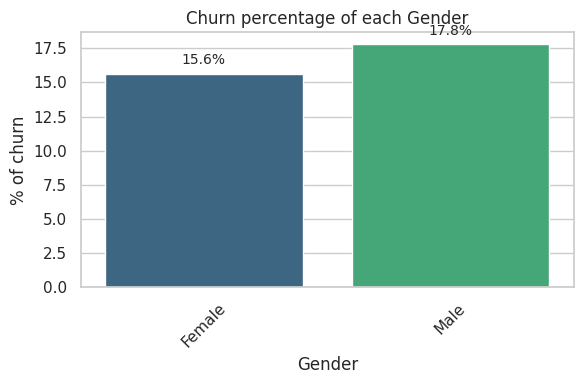

/tmp/ipython-input-46-1577509195.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = churn_pct.index, y = churn_pct.values, palette='viridis')


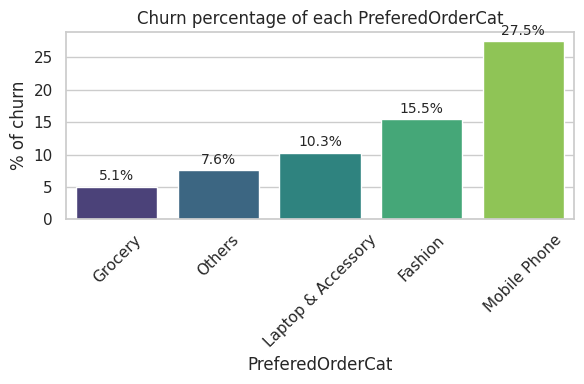

/tmp/ipython-input-46-1577509195.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = churn_pct.index, y = churn_pct.values, palette='viridis')


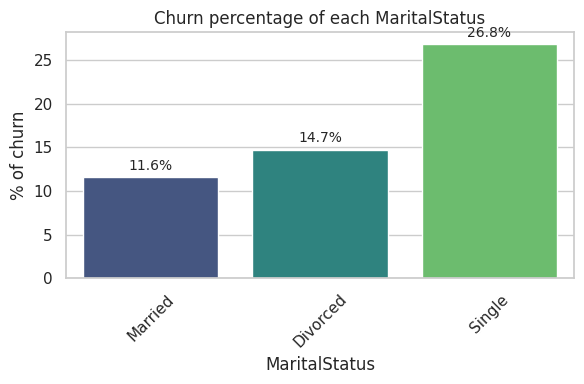

In [ ]:
category_cols = cate_cols.columns

sns.set(style = 'whitegrid')
for col in category_cols:
  # Calculate churn percentage
  churn_pct = churn_df.groupby(col)['Churn'].mean().sort_values()*100

  # Plot
  plt.figure(figsize = (6,4))
  sns.barplot(x = churn_pct.index, y = churn_pct.values, palette='viridis')

  # Add number above each bar:
  for i, value in enumerate(churn_pct.values):
    plt.text(i, value + 0.5, f"{value:.1f}%", ha='center', va='bottom', fontsize=10)

  # Setting the plot
  plt.title(f'Churn percentage of each {col}')
  plt.xlabel(col)
  plt.ylabel('% of churn')
  plt.xticks(rotation = 45)
  plt.tight_layout()
  plt.show()

By the % of churn by all that category in each features, conclusion:
- Login Device: People using Computer tend to churn slightly higher than computer user.
> Some bug on computer version of the app/web?
- Payment Method: the COD mode churn percent was highest
>  So lets have a check on that later
- Gender: The Male churn just a littler bit higher than female,
>  We should investigate whether they gay or not
- Prefer order category: Those prefer mobile phone tend to churn more frequently,
> That's might due to it's is 1 time order only?
- Marital status: Single percent churn more than other peolple.
> Why our service doesn't attached those unmarried person?

In [ ]:
print(churn_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5590 entries, 0 to 5629
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5590 non-null   int64  
 1   Churn                        5590 non-null   int64  
 2   Tenure                       5590 non-null   float64
 3   WarehouseToHome              5590 non-null   float64
 4   PreferredPaymentMode         5590 non-null   object 
 5   NumberOfDeviceRegistered     5590 non-null   int64  
 6   PreferedOrderCat             5590 non-null   object 
 7   SatisfactionScore            5590 non-null   int64  
 8   MaritalStatus                5590 non-null   object 
 9   NumberOfAddress              5590 non-null   int64  
 10  Complain                     5590 non-null   int64  
 11  OrderAmountHikeFromlastYear  5590 non-null   float64
 12  CouponUsed                   5590 non-null   float64
 13  OrderCount             

# 3. Machine Learning Model to predict churn user for future data


## 1/ Feature Engineer

In [ ]:
# Unique value of the churn:
for col in cate_cols.columns:
  print(f'{col}: {cate_cols[col].nunique()}')

PreferredLoginDevice: 2
PreferredPaymentMode: 5
Gender: 2
PreferedOrderCat: 5
MaritalStatus: 3


- All 3 object features have few unique value so just one-hot-encode them

In [ ]:
# RUN THIS
# One-hot_Encode these 5 columns:
churn_dummies_raw = pd.get_dummies(churn_df, columns = cate_cols.columns, drop_first = True)
# print(churn_dummies.info())

In [ ]:
# RUN THIS
# Drop customerid column
churn_dummies = churn_dummies_raw.drop(columns= 'CustomerID',axis = 1)
print(churn_dummies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5607 entries, 0 to 5629
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Churn                                5607 non-null   int64  
 1   Tenure                               5607 non-null   float64
 2   CityTier                             5607 non-null   int64  
 3   WarehouseToHome                      5607 non-null   float64
 4   HourSpendOnApp                       5607 non-null   float64
 5   NumberOfDeviceRegistered             5607 non-null   int64  
 6   SatisfactionScore                    5607 non-null   int64  
 7   NumberOfAddress                      5607 non-null   int64  
 8   Complain                             5607 non-null   int64  
 9   OrderAmountHikeFromlastYear          5607 non-null   float64
 10  CouponUsed                           5607 non-null   float64
 11  OrderCount                         

## 2/ Model Training

### a. Split train-evaluate-test

In [ ]:
# Split data into 3 data set: train-evaluate-test
from sklearn.model_selection import train_test_split

# Create X,y data
X = churn_dummies.drop(['Churn'], axis = 1).values
y = churn_dummies['Churn'].values

# Split train-evaluate-test
X_train, X_semi, y_train, y_semi = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
X_eva, X_test, y_eva, y_test = train_test_split(X_semi, y_semi, test_size = 0.5, random_state = 42,stratify = y_semi)
print(X_train.shape)
print(X_test.shape)

(3913, 25)
(839, 25)


### b. Standarization

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_semi_scaled = scaler.transform(X_semi)
X_test_scaled = scaler.transform(X_test)

### c. Training & Evaluating Model

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:55:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:55:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:55:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:55:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:55:15] WARNING: /w

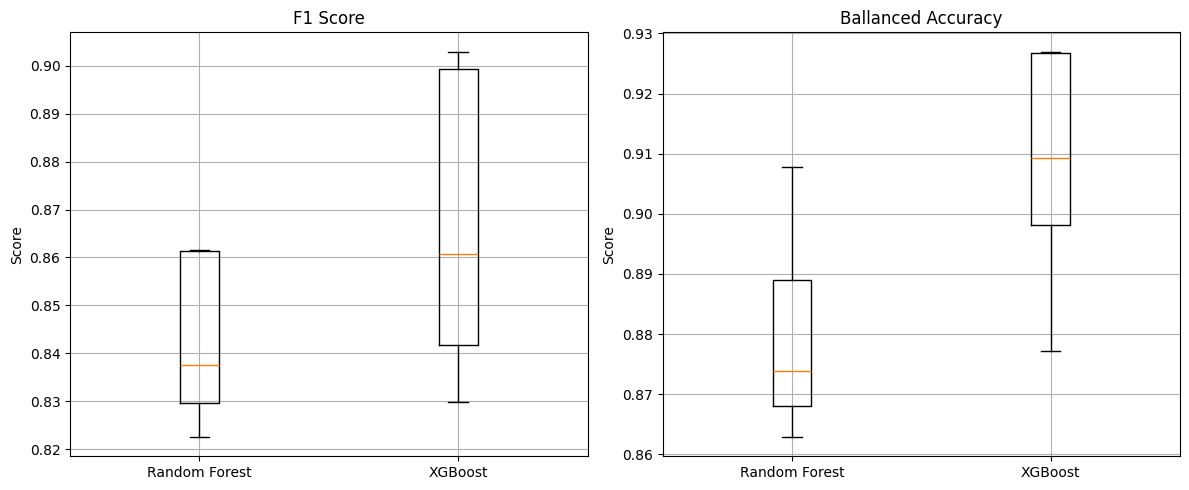

In [ ]:
# Evaluate RandomForest and XGBoost model to train
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score

# Create Model Dictionary
models = {'Random Forest': RandomForestClassifier(),
          'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')}
F1_score = []
Ballanced_Accuracy = []

# Create cross validation and calculate score
for model in models.values():
  kf = KFold(n_splits = 5, random_state = 12, shuffle = True)
  F1_cross_score = cross_val_score(model, X_train_scaled, y_train, cv = kf, scoring = 'f1')
  BA_cross_score = cross_val_score(model, X_train_scaled, y_train, cv = kf, scoring = 'balanced_accuracy')

  F1_score.append(F1_cross_score)
  Ballanced_Accuracy.append(BA_cross_score)

# Boxplot for F1 score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot(F1_score, labels=models.keys())
plt.title("F1 Score")
plt.ylabel("Score")
plt.grid(True)

# Boxplot the
plt.subplot(1, 2, 2)
plt.boxplot(Ballanced_Accuracy, labels=models.keys())
plt.title("Ballanced Accuracy")
plt.ylabel("Score")
plt.grid(True)

plt.tight_layout()
plt.show()

- We can easily see that the XGBoost has higher score in both balanced accuracy and random forest

  => We will use the **XGBoost** to predict churn user

### d. Paremeters Tunning

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBClassifier

# Create cross-validation for param_grid
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Some parameters to test on
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]}

# Running gridsrearch for the best parameter
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring = 'balanced_accuracy', cv = kf)

grid_search.fit(X_train_scaled, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:00:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:00:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:00:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:00:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:00:59] WARNING: /w

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best score: 0.9271187290260683


In [ ]:
# Print the score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best score: 0.9271187290260683




*   The best parameters in practice is {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
*   Accuracy score for the model using these parameters is 0.927, by far the best accuracy score we can acchieve with XGBoost as it showed in the Box chart before

*   So we can deffinitely use XGBoost with these parameters for future prediction, but to assure the assumption, we should check it on the test dataset:





In [ ]:
# Try it on the semi data set:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score

# Create model with best param:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    colsample_bytree= 1.0, learning_rate= 0.2, max_depth= 7, n_estimators= 200, subsample= 1.0)
xgb.fit(X_train_scaled, y_train)

# See how good the model is
y_semi_pred = xgb.predict(X_semi_scaled)
score = balanced_accuracy_score(y_semi, y_semi_pred)
print(f'balanced accuracy score for semi: {score}')

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:27:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


balanced accuracy score for semi: 0.9348811919838176


In [ ]:
# Get the final test dataset:
y_test_pred = xgb.predict(X_test_scaled)
score = balanced_accuracy_score(y_test, y_test_pred)
print(f'balanced accuracy score for final test: {score}')

balanced accuracy score for final test: 0.9280113969325277


 => The ballanced accuracy score for the model is high so we will use XGBoost with these parameter to predict our future churn customers.

# 4. Churned users segmentation

In [ ]:
# Create churn user only table and turn string columns into numeric
churned_user = churn_df[churn_df['Churn'] == 1]
churned_user_dummies = pd.get_dummies(churned_user, cate_cols.columns, drop_first=True)
print(churned_user_dummies)

      CustomerID  Churn  Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
7          53583      1    1.00         1             17.0             4.0   
24         55053      1    1.00         1             17.0             4.0   
40         50768      1    0.80         1             16.0             3.0   
58         52238      1    1.09         1             16.0             3.0   
68         52834      1    1.00         1             14.0             4.0   
...          ...    ...     ...       ...              ...             ...   
5469       53286      1   21.00         1              9.0             3.0   
5494       53604      1    9.00         3              9.0             4.0   
5531       54206      1    5.00         1             19.0             3.0   
5571       54756      1   21.00         1              9.0             3.0   
5596       55074      1    9.00         3              9.0             4.0   

      NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddr

Find how many churned customer segment should be cluster

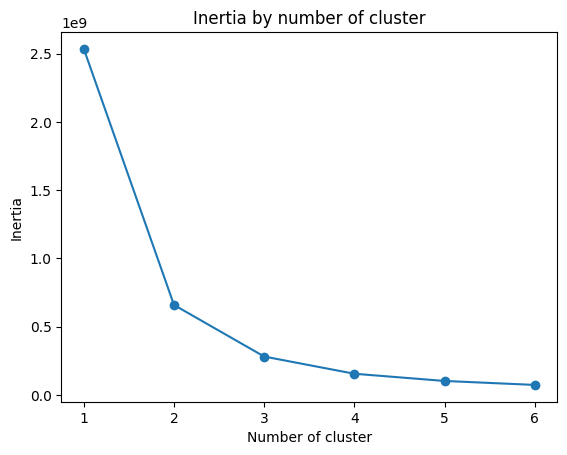

In [ ]:
# Using KMeans to find the best cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

inertia = []
cluster = range(1,7)

# loop through these n_cluster and find inertia
for n in cluster:
  kmeans = KMeans(n_clusters = n)
  kmeans.fit(churned_user_dummies)
  inertia.append(kmeans.inertia_)

# Plot for these cluster inertia
plt.plot(cluster, inertia, '-o')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.title('Inertia by number of cluster')
plt.show()

-> So 3 is a good choice of number cluster, k = 3 in kmeans

In [ ]:
# Scaled churned user dataset
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Drop CustomerID
churned_nocusID = churned_user_dummies.drop(columns = 'CustomerID', axis = 1)

# Scale the dataset:
scaler = StandardScaler(copy = True, with_mean = True, with_std = True)
churned_user_scaled = scaler.fit_transform(churned_nocusID)

# Apply kmeans with k = 3
kmeans = KMeans(n_clusters=3, random_state = 42)
churned_group = kmeans.fit_predict(churned_user_scaled)
# print(churned_group)

# Merge the churned_group to churned_user dataframe
churned_user['Group'] = churned_group
churned_user

/tmp/ipython-input-3000646695.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churned_user['Group'] = churned_group


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,Group
7,53583,1,1.00,Computer,1,17.0,CC,Female,4.0,5,...,4,Single,3,1,26.00,2.0,2.0,1.0,143.59,2
24,55053,1,1.00,Computer,1,17.0,CC,Female,4.0,5,...,4,Single,3,1,26.00,1.0,2.0,1.0,143.59,2
40,50768,1,0.80,Computer,1,16.0,CC,Female,3.0,4,...,4,Single,2,1,25.00,1.0,1.0,0.0,118.59,2
58,52238,1,1.09,Computer,1,16.0,CC,Female,3.0,4,...,4,Single,2,1,25.00,0.0,1.0,0.0,118.59,2
68,52834,1,1.00,Computer,1,14.0,Debit Card,Male,4.0,6,...,3,Single,3,1,25.00,2.0,2.0,7.0,185.74,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5469,53286,1,21.00,Mobile Phone,1,9.0,Debit Card,Male,3.0,4,...,4,Single,9,1,15.98,6.0,14.0,9.0,317.46,0
5494,53604,1,9.00,Mobile Phone,3,9.0,E wallet,Female,4.0,6,...,4,Single,4,1,16.88,1.0,2.0,12.0,313.24,0
5531,54206,1,5.00,Mobile Phone,1,19.0,COD,Female,3.0,4,...,3,Married,3,0,17.26,2.0,16.0,9.0,320.45,0
5571,54756,1,21.00,Mobile Phone,1,9.0,Debit Card,Male,3.0,4,...,4,Single,9,1,16.25,8.0,14.0,9.0,317.46,0


In [ ]:
# Number of users each group
churn_user = churned_user.groupby('Group').size()
df = pd.DataFrame({
        'Group': churn_user.index,
        'Number of User': churn_user.values
})
df

,Group,Number of User
0,0,20
1,1,362
2,2,563


In [ ]:
numeric_churned = churned_user.select_dtypes(exclude = 'object')
numeric_churned.groupby('Group').mean()


,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
Group,,,,,,,,,,,,,,,
0,52601.500000,1.0,13.500000,1.800000,10.500000,2.900000,4.300000,3.500000,4.700000,0.600000,15.493000,3.793500,7.700000,8.500000,307.138000
1,52806.295580,1.0,4.732072,2.309392,19.340525,2.964088,3.892265,3.334254,5.229282,0.458564,15.325967,2.272238,3.922348,4.932652,186.181271
2,52718.413854,1.0,1.921723,1.518650,15.738224,2.895204,3.950266,3.428064,3.911190,0.582593,15.804618,1.307282,2.044405,2.241563,138.569218


In [ ]:
numeric_churned.groupby('Group').median()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
Group,,,,,,,,,,,,,,,
0,52631.5,1.0,1.0,3.0,19.00,3.0,4.0,3.0,5.0,0.0,15.0,1.0,2.0,3.0,176.465
1,53391.5,1.0,9.5,1.0,14.00,3.0,4.0,3.0,3.0,0.5,14.0,5.0,8.0,8.0,223.610
2,52700.0,1.0,1.0,1.0,14.26,3.0,4.0,3.0,3.0,1.0,14.0,1.0,2.0,2.0,139.190


For the Group 1, the average distance from their home to warehouses is nearly 20km, higher than 2 others group by 34%, and their average city tier is high mean that they mostly live in small city or town.
> Investigate more about the shipment time, that could effect on the customer experience

For the Group 0, they seem to be long term user who stay with us for more than a year. Made nearly 8 orders each person, they also used average of 4 coupons, means that 63% of their purchased had coupons with it (assume 1 purchased can only has 1 coupon). And they also had a huge cashback amount by more than 307$. But their average Day since last order is far older than 2 other groups.
> It could be that this type of user love coupons  and cashback, perhaps they haven't earned any of those promotions recently.

>=> Run some voucher or cashback campaign targeting these type of customer.

For the Group 2, this is the bigest group in this clustering with 560 people. As the table show, their averagae tenure is 2 month, their average Order count is not even 2. It's also show that 65% of these order have coupons with it.
> These could be some new user that try using the company service (maybe because our coupons), need more investigate on these customers journey.

In [ ]:
churned_user.groupby('Group')['SatisfactionScore'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
0,270.0,3.455556,1.325987,1.0,3.0,3.0,5.0,5.0
1,118.0,3.169492,1.391704,1.0,2.0,3.0,4.0,5.0
2,557.0,3.411131,1.337647,1.0,3.0,3.0,5.0,5.0


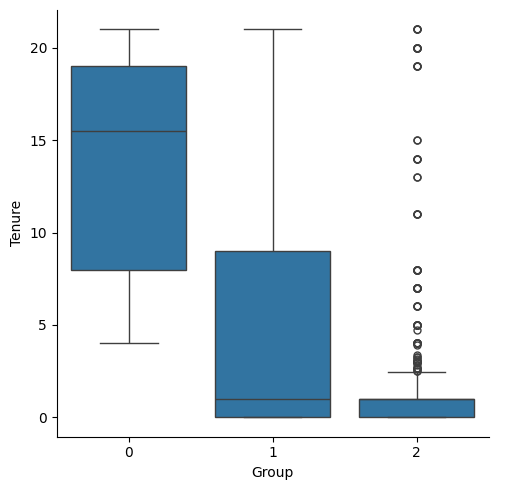

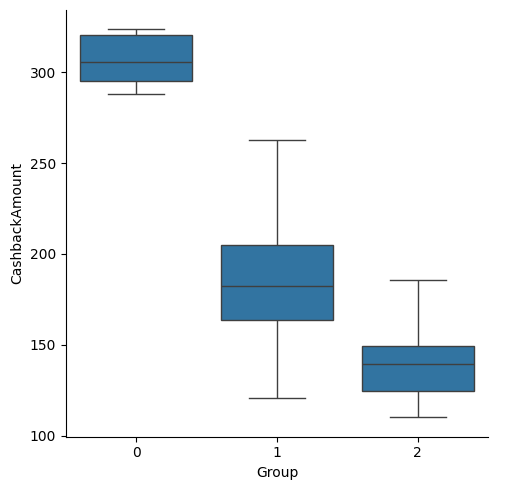

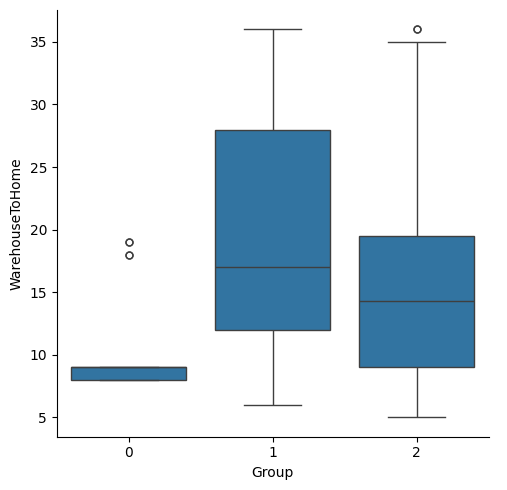

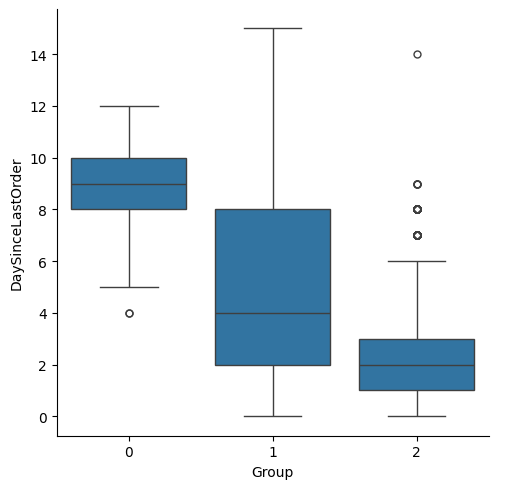

In [ ]:
sns.catplot(x = 'Group', y = 'Tenure', data = churned_user, kind ='box')
sns.catplot(x = 'Group', y = 'CashbackAmount', data = churned_user, kind ='box')
sns.catplot(x = 'Group', y = 'WarehouseToHome', data = churned_user, kind ='box')
sns.catplot(x = 'Group', y = 'DaySinceLastOrder', data = churned_user, kind ='box')

plt.show()


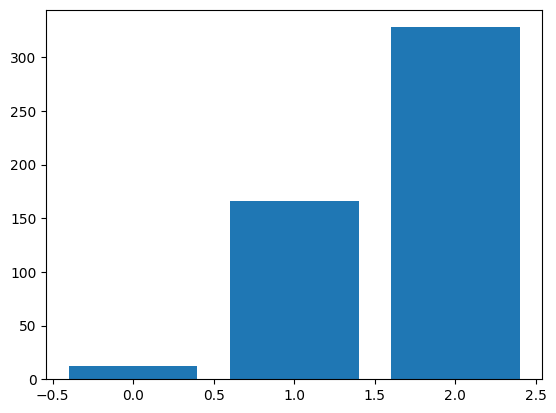

In [ ]:
total_complain = churned_user.groupby('Group')['Complain'].sum()
average_complain = total_complain/churned_user.groupby('Group').sum()
plt.bar(total_complain.index, total_complain.values)
plt.show()

After some investigate, can bring some insight:

The group 0 has Tenure significantly larger than the 3 other group
> Run some advertise like "Long Term Customer Gifts"

Group 1 has total number of complain much higher than 2 other group
> Run some campaign like better customer services

Group 2 has ware house to home kinda far
> Give some free ship voucher


In [ ]:
from sklearn.ensemble import RandomForestClassifier

churned_user_dummies = pd.get_dummies(churned_user, columns = cate_cols.columns, drop_first=True)

# Split the group value to training
X = churned_user_dummies.drop(columns='Group', axis = 1)
y = churned_user_dummies['Group']
feature_names = X.columns

# Lưu feature quan trọng nhất mỗi group
top_features = {}

for group in sorted(y.unique()):
    # Tạo nhãn nhị phân: 1 nếu thuộc group, 0 nếu không
    y_binary = (y == group).astype(int)

    # Huấn luyện mô hình
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X, y_binary)

    # Lấy feature quan trọng nhất
    importances = clf.feature_importances_
    top_idx = np.argmax(importances)
    top_features[group] = (feature_names[top_idx], importances[top_idx])

# In kết quả
for group, (feature, score) in top_features.items():
    print(f"Group {group}: {feature} (importance = {score:.4f})")


Group 0: OrderCount (importance = 0.1898)
Group 1: PreferedOrderCat_Mobile Phone (importance = 0.3559)
Group 2: PreferedOrderCat_Mobile Phone (importance = 0.2817)


As we can see the result show that group 0 has